__Нейросетевая языковая модель на основе LSTM__ 

Евгений Борисов <esborisov@sevsu.ru>

In [1]:
# загружаем текст
import gzip
# with gzip.open('../data/dostoevsky-besy-p2.txt.gz','rt',encoding='utf-8') as f: data = f.read()     
with gzip.open('../data/lobas-taxisty.txt.gz','rt',encoding='utf-8') as f: data = f.read()     
print(len(data))

602297


In [2]:
print(data[:512])

Желтые короли. Записки нью-йоркского таксиста.

В.Лобас



Товарищам моим - белым и черным, американцам и эмигрантам из России и Израиля, из Греции и Кореи, арабам, китайцам, полякам и всем прочим таксистам города Нью-Йорк в знак глубокого уважения к их нечеловеческому труду эту горькую книгу посвящаю...

Водитель No 320718


"Я никогда не знал бы многое из того что я знаю, и половины чего достаточно, чтобы отравить навсегда несколько человеческих жизней, если бы мне не пришлось сделаться шофером такси..." 


In [3]:
# print(data[:1024*100])

In [4]:
# выполняем токенизацию

from nltk.tokenize import sent_tokenize as nltk_sentence_split
from nltk.tokenize import word_tokenize as nltk_tokenize_word

# специальные токены
PAD = '<UNK>' # пусто
EOS = '<EOS>' # конец предложения

text = [ 
    nltk_tokenize_word(s,language='russian')+[EOS] # разбиваем предложения на слова
    for s in nltk_sentence_split(data,language='russian') # режем текст на отдельные предложения
]

del data

len(text)

6765

In [5]:
# text = text[1:1024*4]
# text

In [6]:
# формируем словарь 
import itertools

# список токенов за исключением специальных
words = sorted( set(itertools.chain(*text)) - set([PAD,EOS]) ) 

# нумеруем токены
word2index = { w:i+2 for i,w in enumerate(words) }
del words

# нумеруем специальные токены
word2index[PAD]=0
word2index[EOS]=1

# обратное преобразование из номера в токен
index2word = { i:w for  w,i in word2index.items() }

total_words = len(word2index) # всего токенов в словаре

total_words

24324

In [7]:
# собираем датасет [ левый контекст, слово ]
import numpy as np
import keras.utils as ku 

seq_len = 16+1 # размер левого контекста + 1 слово

sequences = np.array([
    [ word2index[token] for token in sentence[i:i+seq_len] ] # собираем токены и их левые контексты
    for sentence in text if len(sentence)>seq_len # все предложения, которые длиннее размера контекста  
    for i in range(len(sentence)-seq_len) # двигаем окно размера seq_len по предложению
])

# sequences.shape

inputs = sequences[:,:-1] # контексты
targets = sequences[:,-1] # целевые токены для контекстов 

del sequences

# выполняем OHE, конвертируем номера токенов targets в векторы {0,1}
targets = ku.np_utils.to_categorical(targets, num_classes=total_words)

inputs.shape, inputs.dtype, targets.shape, targets.dtype

((43182, 16), dtype('int64'), (43182, 24324), dtype('float32'))

In [8]:
# собираем языковую модель

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
    
model = Sequential()
model.add(Embedding(total_words, 128, input_length=inputs.shape[1]))
model.add(LSTM(1024))
# model.add(LSTM(128,return_sequences=True))
# model.add(LSTM(128))
model.add(Dense(targets.shape[1], activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

2022-03-24 11:54:01.206763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:54:01.234915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:54:01.235092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 11:54:01.235656: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
model.summary() # описание нейросети

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 128)           3113472   
                                                                 
 lstm (LSTM)                 (None, 1024)              4722688   
                                                                 
 dense (Dense)               (None, 24324)             24932100  
                                                                 
Total params: 32,768,260
Trainable params: 32,768,260
Non-trainable params: 0
_________________________________________________________________


In [10]:
%%time 

# обучем модель по левому контексту предсказывать следующий за ним токен
history = model.fit( 
    inputs,
    targets, 
    epochs=10, 
    verbose=1,
)

2022-03-24 11:54:02.992911: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4201435872 exceeds 10% of free system memory.
2022-03-24 11:54:05.750221: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4201435872 exceeds 10% of free system memory.


Epoch 1/10
   3/1350 [..............................] - ETA: 38s - loss: 10.0980 - accuracy: 0.0000e+00  

2022-03-24 11:54:08.734762: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


1350/1350 [==============================] - 40s 29ms/step - loss: 7.5286 - accuracy: 0.1053
Epoch 2/10
1350/1350 [==============================] - 39s 29ms/step - loss: 6.5962 - accuracy: 0.1267
Epoch 3/10
1350/1350 [==============================] - 39s 29ms/step - loss: 5.8713 - accuracy: 0.1401
Epoch 4/10
1350/1350 [==============================] - 39s 29ms/step - loss: 4.7266 - accuracy: 0.1772
Epoch 5/10
1350/1350 [==============================] - 39s 29ms/step - loss: 2.9790 - accuracy: 0.3676
Epoch 6/10
1350/1350 [==============================] - 39s 29ms/step - loss: 1.4361 - accuracy: 0.6769
Epoch 7/10
1350/1350 [==============================] - 39s 29ms/step - loss: 0.6444 - accuracy: 0.8606
Epoch 8/10
1350/1350 [==============================] - 39s 29ms/step - loss: 0.2593 - accuracy: 0.9573
Epoch 9/10
1350/1350 [==============================] - 39s 29ms/step - loss: 0.1018 - accuracy: 0.9901
Epoch 10/10
1350/1350 [==============================] - 39s 29ms/step - lo

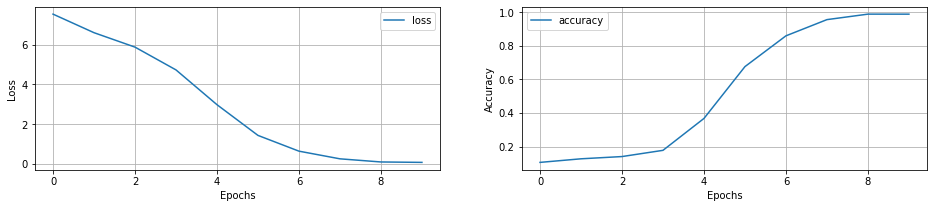

In [11]:
from matplotlib import pyplot as plt

# изменение значений ф-ции потери и погрешности в процессе обучения модели

loss = { k:history.history[k] for k in history.history if k.find('loss')>-1 }  
accuracy = { k:history.history[k] for k in history.history if k.find('acc')>-1 }  

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,3))

for k in loss: 
    ax1.plot(loss[k], label=k)
    ax1.legend()    
    ax1.grid()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    
    
for k in accuracy: 
    ax2.plot(accuracy[k], label=k)
    ax2.legend()    
    ax2.grid()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    
plt.show()

In [12]:
# тестируем модель

from numpy import random as rng
from random import sample
from keras.preprocessing.sequence import pad_sequences

# выбираем случайный контекст из исходных данных
def get_sample(text,seq_len=seq_len-2,max_seq_len=seq_len-1):
    assert seq_len<max_seq_len
    for _ in range(100):
        sentence = sample(text,1)[0]
        if len(sentence)>seq_len*2:
            i = rng.randint(len(sentence)-seq_len*2)
            return sentence[i:i+seq_len]
    return [PAD,]

# кодируем контекст
def encode_sentence(sentence,word2index=word2index,max_seq_len=seq_len-1):
    return np.array(
            pad_sequences(
                [[ word2index[token] for token in sentence ],], 
                maxlen=max_seq_len, 
                padding='pre',
            )
        )

# encode_sentence(get_sample(text)).shape

In [15]:
for __ in range(10):

    sentence0 = get_sample(text) # выбираем контекст
    answer = [] # предсказанные токены
    sentence = [PAD]+sentence0 # начальный контекст

    for _ in range(27):
        sequence = encode_sentence(sentence[1:]) # кодируем контекст
        predicted_index = np.argmax( model.predict(sequence) ) # продолжение контекста то модели 
        predicted_word = index2word[predicted_index] # декодируем ответ модели
        answer.append(predicted_word) # запоминаем токен предсказанный моделью
        if predicted_index == word2index[EOS]: break # если предсказан конец предложения то завершаем
        sentence.append(predicted_word) # предсказанный токен в контекст
        
    print('\n'+'init> '+' '.join(sentence0)+'\n'+'lstm> ' + ' '.join(answer) )
    print(' - '*30 )    


init> арендую и за которую отвечаю головой , слава Богу , ни разу не угоняли ,
lstm> но автомобили в Нью-Йорке воруют так часто , что у меня выработался такой вот рефлекс . . , и , едва быть , о котором пятого ,
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 

init> Остановившись у тележки с горячими бубликами , я заглатываю - мне больно жевать - безвкусное
lstm> педерастов и наблюдаю , как шагах в десяти ... - Это сотрудник не согласен с политикой учреждения , в котором служит , - натужно , с фальшивинкой
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 

init> на девятнадцатом этаже дома , расположенного через дорогу от океана , в Бруклине , я
lstm> первым делом выглядываю в окно , чтобы проверить , стоит ли мой кэб там , где я поставил его с вечера . , чуть ли не заслуживающей
 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 

init> еще кое-кто из моих земляк